# Laboratorio 4: Clasificación de Imágenes con CNN (CIFAR-10)

**Integrantes**
- José Rodrigo Marchena, 22398  
- Sofía Velasquez, 22049  

**Objetivo general**  
Implementar y comparar un modelo base ANN y una CNN para clasificar el dataset CIFAR-10,evaluando desempeño, curvas de aprendizaje y errores comunes. También se incluye un ejercicio opcional de Data Augmentation.

---

## Parte 1: Preparación del Conjunto de Datos

1. Cargamos el dataset CIFAR-10 directamente desde `keras.datasets`.  
   - Son 60,000 imágenes de tamaño 32x32x3 (RGB).  
   - Se dividen en 50,000 de entrenamiento y 10,000 de prueba.  
2. Normalizamos los valores de píxeles, dividiéndolos entre 255, de modo que los valores queden en el rango [0,1]
3. Definimos los nombres de las clases (avión, coche, perro, etc.).  
4. Mostramos 10 imágenes de entrenamiento con sus etiquetas para confirmar que los datos están bien cargados.

Shapes -> x_train: (50000, 32, 32, 3) y_train: (50000, 1)
Shapes -> x_test: (10000, 32, 32, 3) y_test: (10000, 1)


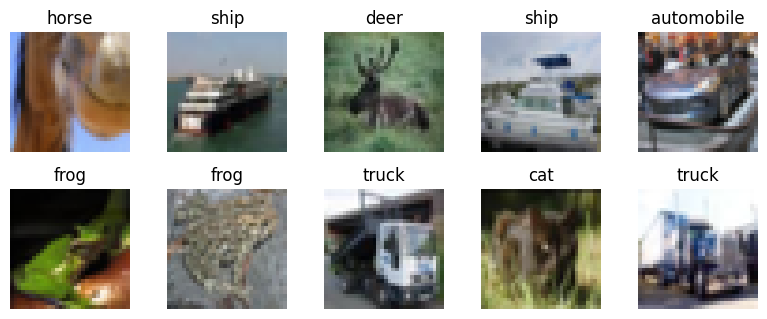

In [1]:
# Carga de CIFAR-10
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

print("Shapes -> x_train:", x_train.shape, "y_train:", y_train.shape)
print("Shapes -> x_test:", x_test.shape, "y_test:", y_test.shape)

# Normalización [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Visualización de 10 ejemplos
def show_grid(images, labels, n=10):
    plt.figure(figsize=(8,8))
    idx = np.random.choice(len(images), n, replace=False)
    for i, j in enumerate(idx):
        plt.subplot(5,5,i+1)
        plt.imshow(images[j])
        plt.title(class_names[labels[j][0]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_grid(x_train, y_train)

### Parte 2: Modelo Base ANN

Aquí implementamos una **red neuronal artificial densa (ANN)** como referencia:

- Se aplana la imagen (32×32×3 → 3072 neuronas).  
- Dos capas densas ocultas con activación **ReLU**.  
- Capa final `Dense(10)` con activación **Softmax** para clasificar las 10 clases.  

Se compila el modelo con:
- **Optimizer:** Adam.  
- **Loss:** `categorical_crossentropy`.  
- **Métrica:** Accuracy.  

Luego lo entrenamos, medimos tiempo de entrenamiento y evaluamos el rendimiento en el set de prueba.

In [2]:
import time
from tensorflow.keras.utils import to_categorical

# One-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

def build_ann(input_shape=(32,32,3), num_classes=10):
    model = keras.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

ann = build_ann()
ann.summary()

c:\Users\50250\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,274 (6.51 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# Entrenamiento ANN (midiendole el tiempo)
batch_size = 64
epochs = 10

start = time.time()
hist_ann = ann.fit(
    x_train, y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2
)
t_train_ann = time.time() - start
print(f"Tiempo de entrenamiento ANN: {t_train_ann:.2f} s")

# Evaluación del modelo en test
test_loss_ann, test_acc_ann = ann.evaluate(x_test, y_test, verbose=0)
print(f"[ANN] Test Acc: {test_acc_ann:.4f} | Test Loss: {test_loss_ann:.4f}")


Epoch 1/10
625/625 - 8s - 13ms/step - accuracy: 0.3195 - loss: 1.8986 - val_accuracy: 0.3467 - val_loss: 1.8317
Epoch 2/10
625/625 - 7s - 11ms/step - accuracy: 0.3917 - loss: 1.6934 - val_accuracy: 0.4099 - val_loss: 1.6603
Epoch 3/10
625/625 - 7s - 11ms/step - accuracy: 0.4293 - loss: 1.6028 - val_accuracy: 0.4329 - val_loss: 1.6097
Epoch 4/10
625/625 - 7s - 11ms/step - accuracy: 0.4505 - loss: 1.5445 - val_accuracy: 0.4561 - val_loss: 1.5371
Epoch 5/10
625/625 - 8s - 13ms/step - accuracy: 0.4616 - loss: 1.5033 - val_accuracy: 0.4413 - val_loss: 1.5924
Epoch 6/10
625/625 - 8s - 12ms/step - accuracy: 0.4748 - loss: 1.4710 - val_accuracy: 0.4556 - val_loss: 1.5197
Epoch 7/10
625/625 - 8s - 12ms/step - accuracy: 0.4856 - loss: 1.4357 - val_accuracy: 0.4731 - val_loss: 1.4921
Epoch 8/10
625/625 - 7s - 11ms/step - accuracy: 0.4895 - loss: 1.4183 - val_accuracy: 0.4616 - val_loss: 1.5117
Epoch 9/10
625/625 - 7s - 12ms/step - accuracy: 0.5021 - loss: 1.3922 - val_accuracy: 0.4726 - val_loss: